In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba

### Grid 

In [3]:
class Grid:
    def __init__(self, xmin: float, xmax: float, nx: int, n_ghost: int = 1):
        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx
        self.tot_nx = nx + 2 * n_ghost
        self.dx = (xmax - xmin) / (nx - 1)
        self.x = np.linspace(xmin, xmax, nx)
        self.x = np.insert(self.x, 0, self.x[0])
        self.x = np.insert(self.x, self.x.shape[0], self.x[-1])

### Primitive variables to conserved variables

In [4]:
@numba.njit
def prim_to_cons_vars(pv: np.ndarray) -> np.ndarray:
    cv = np.zeros(pv.shape)
    cv[:, 0] = pv[:, 0]
    cv[:, 1] = pv[:, 0] * pv[:, 1]
    cv[:, 2] = pv[:, 0] * (pv[:, 2] / (pv[:, 0] * (1.4 - 1)) + 0.5 * pv[:, 1] ** 2)

    return cv

### Conserved variables to primitive variables

In [5]:
@numba.njit
def cons_to_prim_vars(cv: np.ndarray) -> np.ndarray:
    pv = np.zeros(cv.shape)
    pv[:, 0] = cv[:, 0]
    pv[:, 1] = cv[:, 1] / cv[:, 0]
    pv[:, 2] = (cv[:, 2] / cv[:, 0] - 0.5 * pv[:, 1] ** 2) * cv[:, 0] * (1.4 - 1)

    return pv

### Conserved variables to flux

In [6]:
@numba.njit
def conv_vars_to_flux(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    f = np.zeros(cv.shape)
    f[:, 0] = cv[:, 1]
    f[:, 1] = pv[:, 2] + cv[:, 1] * pv[:, 1]
    f[:, 2] = pv[:, 2] * pv[:, 1] + cv[:, 2] * pv[:, 1]

    return f

### To compute time step

In [7]:
@numba.jit
def time_step(cv: np.ndarray, dx: float, cfl: float = 0.2) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val = np.abs(pv[:, 1] + a)
    dt = cfl * dx / eig_val
    
    return np.min(dt)

### To compute Rusanov (LLF) flux

In [8]:
@numba.njit
def llf_flux(cv: np.ndarray) -> np.ndarray:
    f = conv_vars_to_flux(cv)
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    f_iph=np.zeros(f.shape)
    f_imh=np.zeros(f.shape)
    for i in range(1, cv.shape[0]-1):
        eig_val_l = np.abs(pv[i, 1]) + a[i]
        eig_val_r = np.abs(pv[i+1, 1]) + a[i+1]
        max_eig_val = np.maximum(eig_val_l, eig_val_r)
        f_iph[i] = 0.5 * (f[i, :] + f[i+1, :]) - 0.5 * max_eig_val * (cv[i+1, :] - cv[i, :])

    for i in range(1, cv.shape[0]-1):
        eig_val_l = np.abs(pv[i-1, 1]) + a[i-1]
        eig_val_r = np.abs(pv[i, 1]) + a[i]
        max_eig_val = np.maximum(eig_val_l, eig_val_r)
        f_imh[i] = 0.5 * (f[i, :] + f[i-1, :]) - 0.5 * max_eig_val * (cv[i, :] - cv[i-1, :])

    return f_iph - f_imh

### Initial and boundary conditions

In [9]:
def initialize(pv_l: np.ndarray, pv_r: np.ndarray, x: np.ndarray, pv: np.ndarray, xloc):
    pv[np.argwhere(x <= xloc), :] = pv_l
    pv[np.argwhere(x > xloc), :] = pv_r
    
def bc(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    pv[0,:] = pv[1,:]
    pv[-1,:] = pv[-2,:]
    con_var = prim_to_cons_vars(pv)

    return con_var

### Simulation parameters

In [12]:
prim_var_l = np.array([1.0, 0.75, 1.0])
prim_var_r = np.array([0.125, 0.0, 0.1])

cfl_num = 0.9
grid = Grid(0, 1, 11)
x_grid = grid.x
x_loc = 0.3
prim_var = np.zeros((x_grid.size, 3))
initialize(prim_var_l, prim_var_r, x_grid, prim_var, x_loc)

cons_var = prim_to_cons_vars(prim_var)
flux = conv_vars_to_flux(cons_var)
prim_var = cons_to_prim_vars(cons_var)

print(llf_flux(cons_var))

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.47078198 -0.00629402  1.0287577 ]
 [-1.22078198 -1.45620598 -3.8646952 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


### Run the simulation

In [26]:
%%time
time = 0
while time <= 0.2:
    t_dt = time_step(cons_var, grid.dx, cfl_num)
    flux = llf_flux(cons_var)
    cv_new = cons_var - (t_dt / grid.dx) * flux
    cons_var = bc(cv_new)
    time += t_dt
    print(time)

0.00010920828178686061
0.00021841656140415513
0.0003276248388466742
0.0004368331141249236
0.0005460413872318551
0.000655249658175369
0.0007644579269554385
0.000873666193572945
0.0009828744580348497
0.0010920827203350486
0.0012012909804838998
0.0013104992384754628
0.0014197074943165355
0.001528915748008106
0.001638123999550046
0.0017473322489502396
0.001856540496201665
0.001965748741314542
0.0020749569842840434
0.0021841652251158583
0.0022933734638119975
0.0024025817003713156
0.002511789934802628
0.0026209981670979863
0.0027302063972674804
0.0028394146253073885
0.0029486228512222994
0.0030578310750152397
0.003167039296684052
0.0032762475162384794
0.00338545573366965
0.0034946639489875334
0.0036038721621894933
0.0037130803732790363
0.003822288582260189
0.003931496789129798
0.004040704993897719
0.0041499131965557715
0.004259121397113009
0.004368329595567858
0.004477537791922766
0.004586745986182735
0.004695954178343641
0.004805162368415233
0.004914370556390437
0.005023578742277202
0.00513

0.053621037773892134
0.05373024518108583
0.053839452586822864
0.05394865999110581
0.05405786739393278
0.05416707479530974
0.0542762821952314
0.05438548959370394
0.05449469699072506
0.054603904386297725
0.05471311178042303
0.054822319173100556
0.05493152656433476
0.05504073395412188
0.05514994134246803
0.05525914872936945
0.05536835611483057
0.05547756349885098
0.05558677088143178
0.055695978262575885
0.05580518564228105
0.055914393020553343
0.05602360039738754
0.05613280777278954
0.05624201514675744
0.05635122251929381
0.05646042989040005
0.056569637260075446
0.056678844628324676
0.056788051995143723
0.05689725936053861
0.05700646672450595
0.05711567408704979
0.05722488144817003
0.05733408880786744
0.05744329616614518
0.05755250352300076
0.05766171087844015
0.057770918232458494
0.05788012558506131
0.05798933293624699
0.058098540286017804
0.05820774763437539
0.05831695498131878
0.05842616232685283
0.05853536967097334
0.05864457701368624
0.058753784354988424
0.05886299169488365
0.0589721

0.11073633446829291
0.1108455411592619
0.11095474792768535
0.11106395469508736
0.11117316146147083
0.1112823682268352
0.11139157499118145
0.11150078175451095
0.1116099884857666
0.11171919524706397
0.11182840200734406
0.1119376087078976
0.11204681546614874
0.11215602222338669
0.11226522897961162
0.11237443573482377
0.11248364248902522
0.1125928492422143
0.11270205591280616
0.11281126266397491
0.11292046941413536
0.1130296761632865
0.11313888291142975
0.11324808965856599
0.11335729640469475
0.11346650312631734
0.11357570987043433
0.11368491661354786
0.11379412328521066
0.11390333002631553
0.1140125367664171
0.11412174350551602
0.1142309502436139
0.11434015698070957
0.11444936371680647
0.1145585703685757
0.11466777710267254
0.11477698383576973
0.11488619056504452
0.11499539729614651
0.11510460402625106
0.1152138107553605
0.115323017468965
0.11543222419608395
0.1155414309222069
0.11565063756641607
0.11575984429055221
0.11586905101369568
0.11597825773584766
0.11608746445700738
0.11619667117

0.16020257288876188
0.16031177102229538
0.16042096916440746
0.16053016731505304
0.16063936547418742
0.16074856364176623
0.16085776181774555
0.16096696000208174
0.16107615819473156
0.1611853563956521
0.1612945546048008
0.16140375282213545
0.16151295104761418
0.16162214928119542
0.16173134752283802
0.16184054577250107
0.16194974403014403
0.16205894229572668
0.1621681405692091
0.16227733885055173
0.1623865371397153
0.1624957354366608
0.16260493374134957
0.1627141320537433
0.1628233303738039
0.1629325287014936
0.16304172703677497
0.1631509253796108
0.16326012372996418
0.16336932208779856
0.16347852045307756
0.1635877188257652
0.16369691720582566
0.16380611559322347
0.1639153139879234
0.1640245123898905
0.16413371079909006
0.16424290921548768
0.16435210763904917
0.16446130606974063
0.16457050450752841
0.1646797029523791
0.16478890140425956
0.1648980998631369
0.1650072983289784
0.1651164968017517
0.16522569528142458
0.16533489376796515
0.16544409226134166
0.16555329076152267
0.16566248926847

### Plot results

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

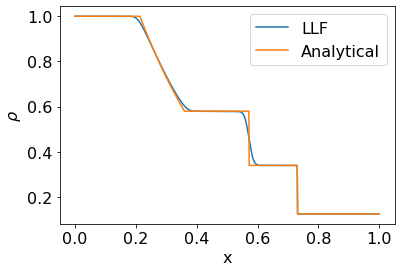

In [15]:
prim_var = cons_to_prim_vars(cons_var)
analytical = np.loadtxt('/mnt/external_data/maruthi/my_codes/compressible_euler_1d/output/shock_tube.dat')
plt.plot(x_grid, prim_var[:, 0], label='LLF')
plt.plot(analytical[:, 0], analytical[:, 1], label='Analytical')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$\rho $', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [12]:
# !numba -s